## Zeroth Step
### Importing Libraries and Loading Data

In [1]:
GC.gc() # Clear up the memory when doing a "run all" in the notebook


include("src/load_profiles.jl")
include("src/print_plot.jl")
include("src/solver.jl");

In [2]:
filename = "profiles.csv"
YEARS = [2014, 2015, 2016, 2017, 2018]
if ! @isdefined(time_profiles) || issubset(YEARS, keys(time_profiles)) == false
    time_profiles, wind_profiles, solar_profiles = load_profiles(filename, YEARS, true)
end;

print("Loaded profiles for years: ", keys(time_profiles), "\n")

Loading the profiles for the year 2014


Loading the profiles for the year 2015
Loading the profiles for the year 2016
Loading the profiles for the year 2017


Loading the profiles for the year 2018
Loaded profiles for years: Any

[2018, 2014, 2017, 2016, 2015]


### We first define the global parameters of the problem, to have consistent results across solving methods

In [3]:
# Default values
DEMAND = 1000. # Kg of H2
# Battery parameters
EBAT = 0.9 # per month discharge
FBAT = 100. # MW
COST_BAT = 250000 * 0.0002 # € / MWh
# Electrolyzer parameters
EELEC = 0.050 # MWh / Kg
COST_ELEC =  1200000 * 0.0004 # € / MW
CAPA_ELEC_UPPER = 1000 # MW
# Tank parameters
COST_TANK = 407. # € / Kg
# Grid parameters
PRICE_GRID = 1000. # € / MWh
PRICE_CURTAILING = 750. # € / MWh;
PRICE_PENALITY = 0 # € / times changed
PRICE_PROD_CHANGE = 1 # € / kg of change in production level
# Renewable pricing, from https://atb.nrel.gov/electricity/2022/index
# For now : 20 year lifespan, no discount rate + O&M cost per year
COST_WIND = 1352 * 1000 / 20 + 43 * 1000 # € / MW
COST_SOLAR = 1233 * 1000 / 20 + 23 * 1000 # € / MW
# Upper bound on the battery capacity
CAPA_BAT_UPPER = 12 * DEMAND * EELEC # MW
#Year chosen for the simulation
YEAR = 2014;

# First Step :
## Solve the problem given the production and storage capacities

In [4]:
# We use the default values for now
BAT_SIZE = 400. # MWh
TANK_SIZE = 500. # Kg
ELEC_CAPA = 1000. # MW
time_index = wind_profiles[YEAR]
wind_profile = wind_profiles[YEAR]
solar_profile = solar_profiles[YEAR]
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = D * length(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile);

In [5]:
output1 = solve(
    wind_profile, solar_profile, # WIND_PROFILE, SOLAR_PROFILE
    DEMAND, # DEMAND
    wind_capa, solar_capa, # WIND_CAPA, SOLAR_CAPA, if set to missing, the solver will optimize it
    BAT_SIZE, TANK_SIZE, ELEC_CAPA, # BAT_SIZE, TANK_SIZE, ELEC_CAPA, if set to missing, the solver will optimize it
    PRICE_GRID, PRICE_CURTAILING, # PRICE_GRID, PRICE_CURTAILING
    PRICE_PENALITY, PRICE_PROD_CHANGE, #PRICE_PENALITY, PRICE_PROD_CHANGE
    CAPA_BAT_UPPER, CAPA_ELEC_UPPER, # CAPA_BAT_UPPER, CAPA_ELEC_UPPER
    EBAT, FBAT, EELEC, # EBAT, FBAT, EELEC
    COST_ELEC, COST_BAT, COST_TANK, # COST_ELEC, COST_BAT, COST_TANK
    COST_WIND, COST_SOLAR, # COST_WIND, COST_SOLAR
    0., # No initial charge
    0., # No initial stock
    missing, # No final charge constraint
    missing, # No final stock constraint
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Adding variables ... 


Adding constraints ... 


Optimizing ...


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96366 rows, 87605 columns and 245281 nonzeros
Model fingerprint: 0x15c99715
Coefficient statistics:
  Matrix range     [5e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 1e+02]
  RHS range        [8e-01, 4e+07]
Presolve removed 70141 rows and 35153 columns
Presolve time: 0.11s
Presolved: 26225 rows, 52452 columns, 104846 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.849e+04
 Factor NZ  : 3.796e+05 (roughly 35 MB of memory)
 Factor Ops : 6.367e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
 

In [6]:
print_solution_propreties(output1)

Battery capacity: 400 MWh, Tank capacity: 500 kg, Electrolyser capacity: 20000.0 kg/h
Wind capacity: 231 MW, Solar capacity: 129 MW 

Wind proportion in capacity: 0.6416666666666667 
Wind proportion in generation: 0.750870304694371 

Total electricity needed: 438000.0 MWh, Total electricity produced: 459900.0 MWh
Total electricity imported: 81905.0 MWh, Total electricity curtailment: 103589.0 MWh 

Produced / Needed ratio : 1.05 

Storage cost: 223500.0, operating cost: 1.5960030264731628e8
Electrolyser cost : 480000.0, electricity plant cost: 3.66109398990877e7
Total cost: 1.9691474254640397e8


In [7]:
prod1, cons1, bat1, tank1 = plot_solution(output1);

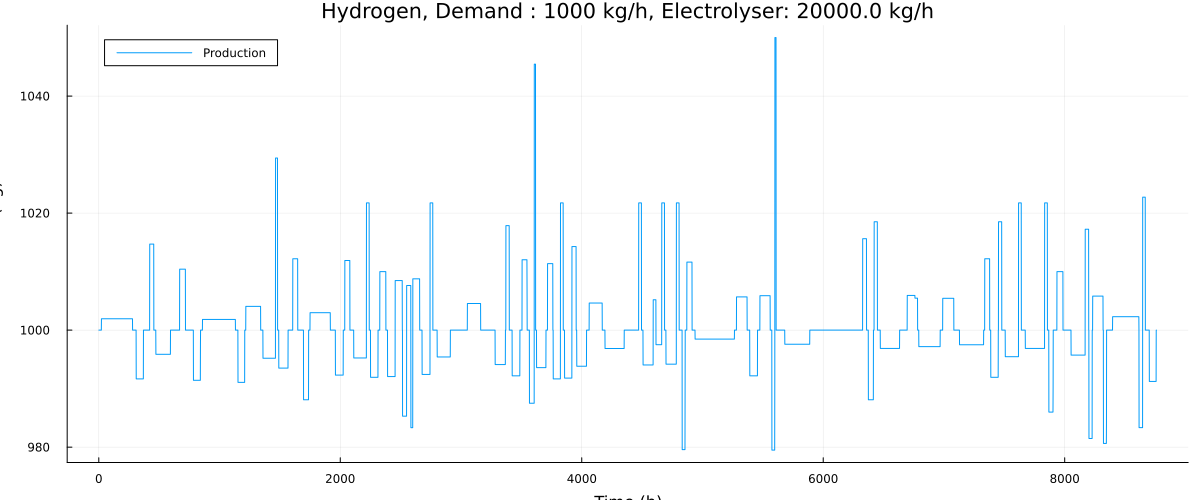

In [8]:
prod1

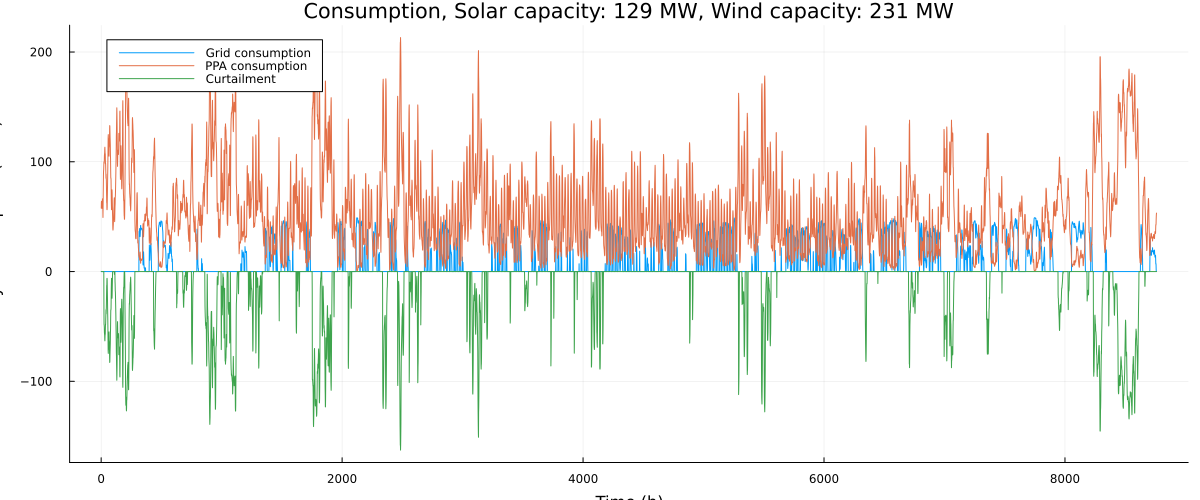

In [9]:
cons1

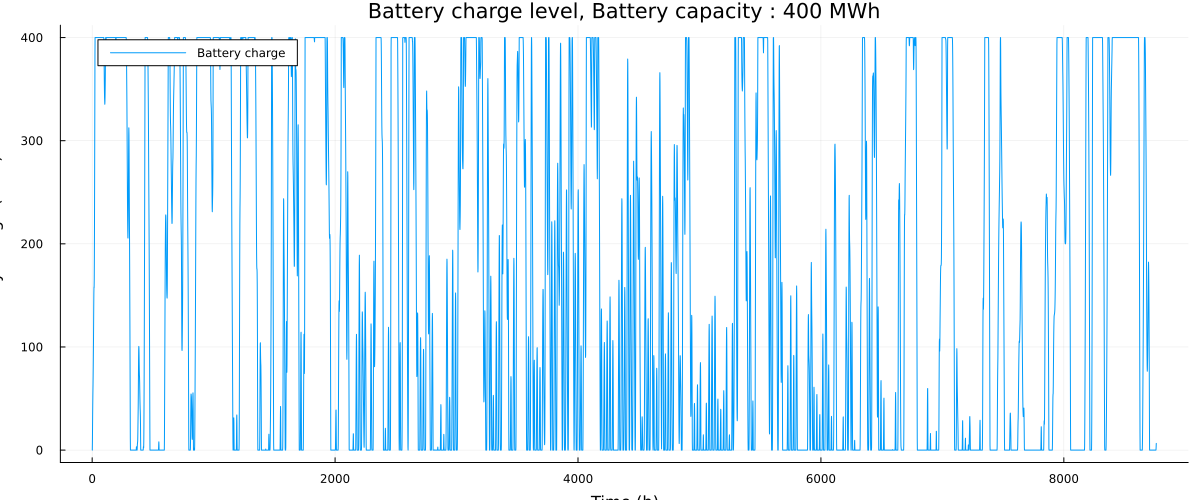

In [10]:
bat1

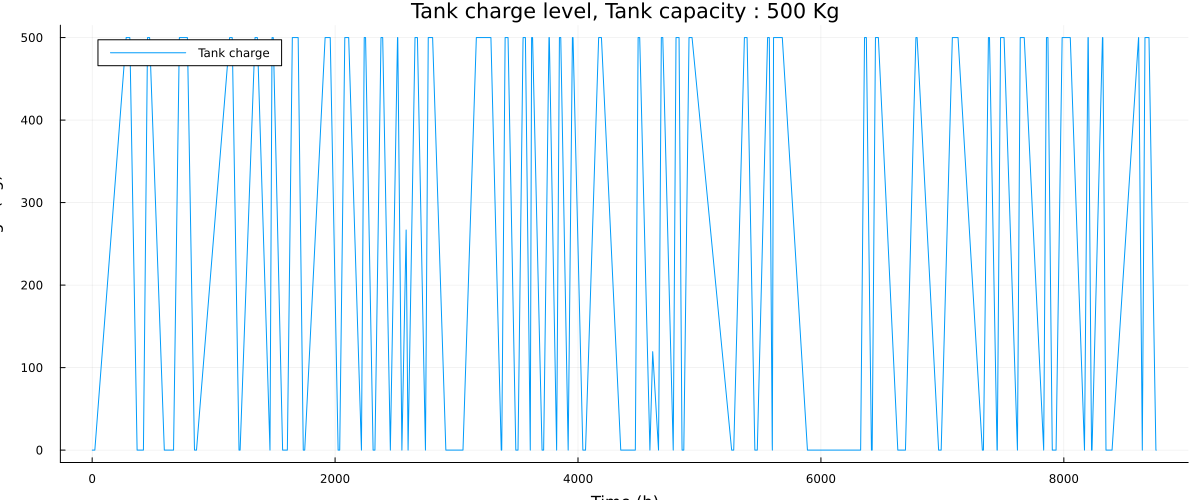

In [11]:
tank1

# Second Step :
## Solve the problem given the production capacities only

In [12]:
# We use the default values for now
D = 1000.
time_index = wind_profiles[YEAR]
wind_profile = wind_profiles[YEAR]
solar_profile = solar_profiles[YEAR]
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = D * length(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile);

In [13]:
output2 = solve(
    wind_profile, solar_profile, # WIND_PROFILE, SOLAR_PROFILE
    DEMAND, # DEMAND
    wind_capa, solar_capa, # WIND_CAPA, SOLAR_CAPA, if set to missing, the solver will optimize it
    missing, missing, missing, # BAT_SIZE, TANK_SIZE, ELEC_CAPA, if set to missing, the solver will optimize it
    PRICE_GRID, PRICE_CURTAILING, # PRICE_GRID, PRICE_CURTAILING
    PRICE_PENALITY, PRICE_PROD_CHANGE, #PRICE_PENALITY, PRICE_PROD_CHANGE
    CAPA_BAT_UPPER, CAPA_ELEC_UPPER, # CAPA_BAT_UPPER, CAPA_ELEC_UPPER
    EBAT, FBAT, EELEC, # EBAT, FBAT, EELEC
    COST_ELEC, COST_BAT, COST_TANK, # COST_ELEC, COST_BAT, COST_TANK
    COST_WIND, COST_SOLAR, # COST_WIND, COST_SOLAR
    0., # No initial charge
    0., # No initial stock
    missing, # No final charge constraint
    missing, # No final stock constraint
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Adding variables ... 
Adding constraints ... 


Optimizing ...


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96366 rows, 87608 columns and 271566 nonzeros
Model fingerprint: 0xbc834381
Coefficient statistics:
  Matrix range     [5e-02, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 1e+03]
  RHS range        [8e-01, 4e+07]
Presolve removed 35049 rows and 26288 columns
Presolve time: 0.42s
Presolved: 18319 rows, 70078 columns, 237276 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Free vars  : 791
 AA' NZ     : 1.154e+05
 Factor NZ  : 2.725e+05 (roughly 40 MB of memory)
 Factor Ops : 4.397e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual   

In [14]:
print_solution_propreties(output2)

Battery capacity: 600 MWh, Tank capacity: 85260 kg, Electrolyser capacity: 1880.0 kg/h
Wind capacity: 231 MW, Solar capacity: 129 MW 

Wind proportion in capacity: 0.6416666666666667 
Wind proportion in generation: 0.750870304694371 

Total electricity needed: 438000.0 MWh, Total electricity produced: 459900.0 MWh
Total electricity imported: 35461.0 MWh, Total electricity curtailment: 54018.0 MWh 

Produced / Needed ratio : 1.05 

Storage cost: 3.4731000189902194e7, operating cost: 7.603553111188175e7
Electrolyser cost : 45411.03062251959, electricity plant cost: 3.66109398990877e7
Total cost: 1.474228822314942e8


In [15]:
prod2, cons2, bat2, tank2 = plot_solution(output2);

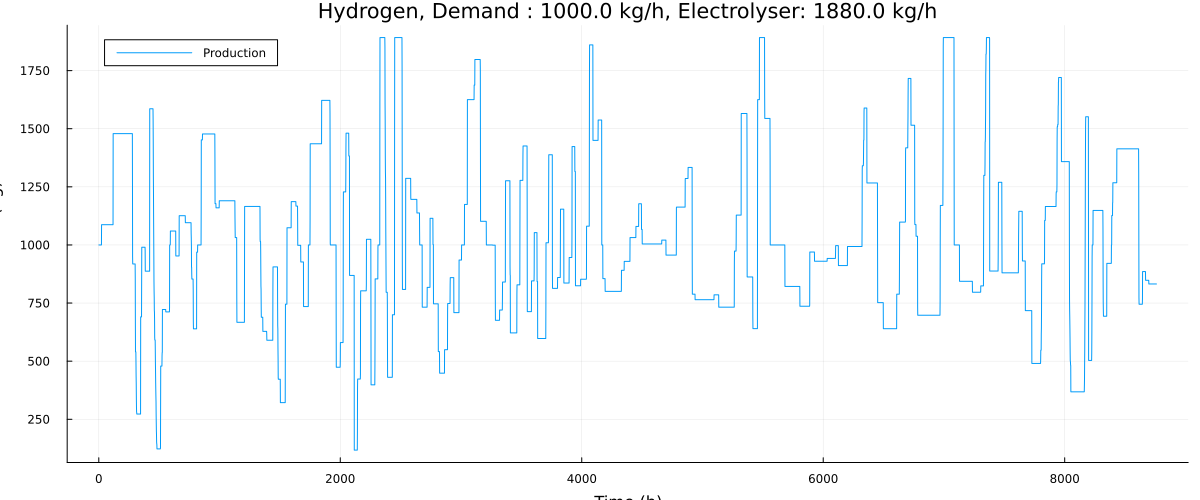

In [16]:
prod2

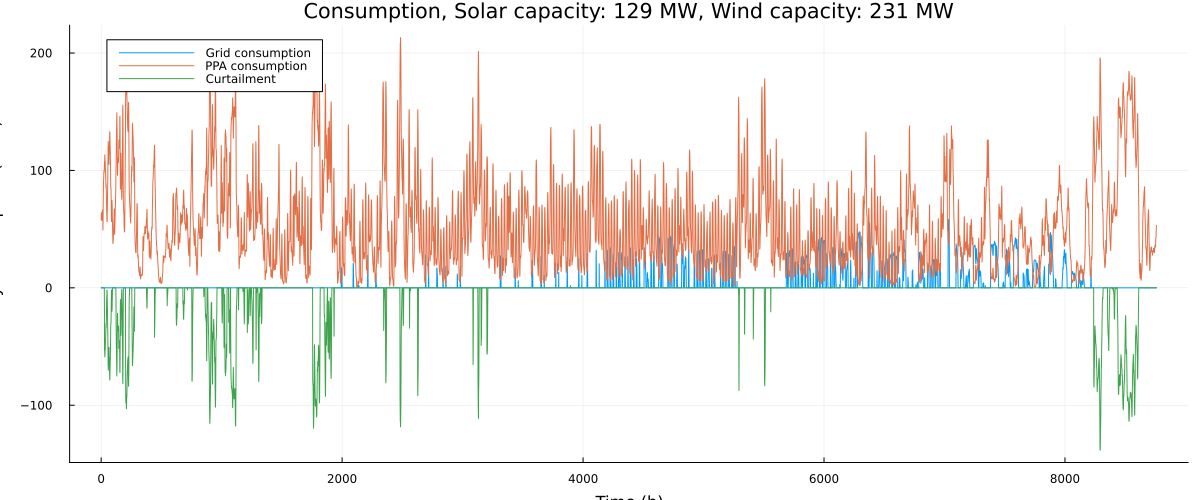

In [17]:
cons2

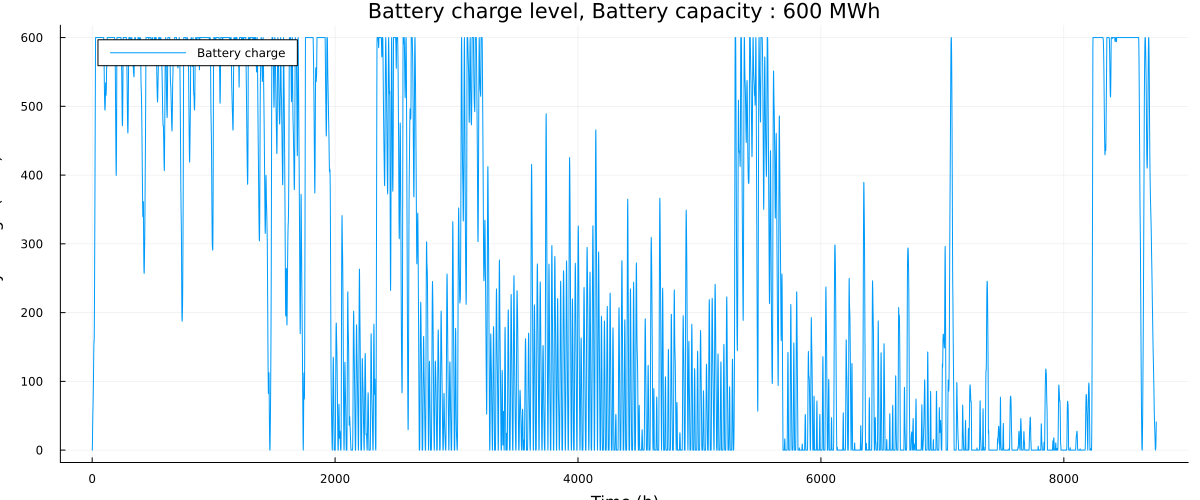

In [18]:
bat2

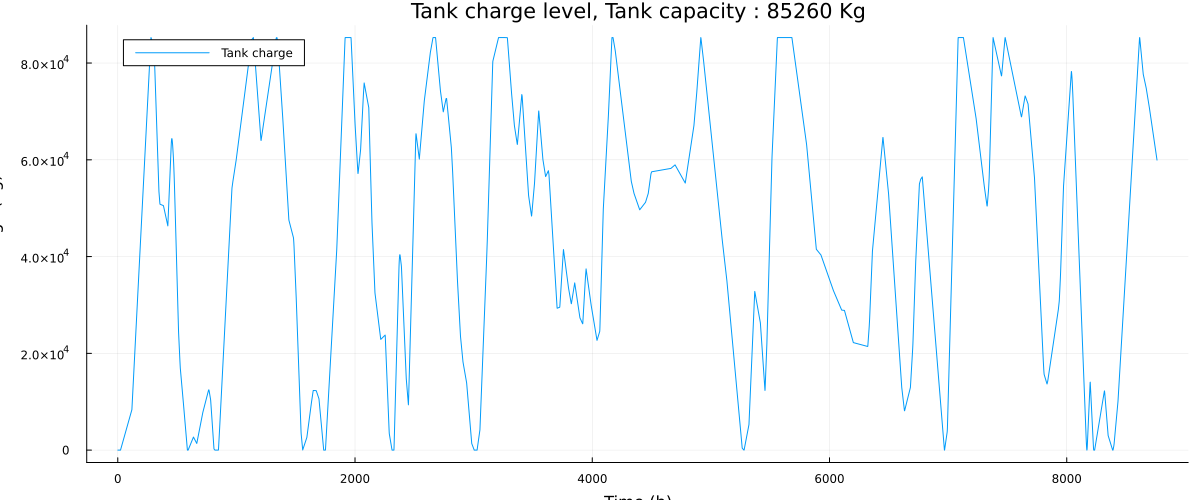

In [19]:
tank2

# Third Step : 
## Solve the problem given the demand only.

In [20]:
D = 1000.
time_index = wind_profiles[YEAR]
wind_profile = wind_profiles[YEAR]
solar_profile = solar_profiles[YEAR];

In [21]:
output3 = solve(
    wind_profile, solar_profile, # WIND_PROFILE, SOLAR_PROFILE
    DEMAND, # DEMAND
    missing, missing, # WIND_CAPA, SOLAR_CAPA, if set to missing, the solver will optimize the capacities
    missing, missing, missing, # BAT_SIZE, TANK_SIZE, ELEC_CAPA, if set to missing, the solver will optimize the capacities
    PRICE_GRID, PRICE_CURTAILING, # PRICE_GRID, PRICE_CURTAILING
    PRICE_PENALITY, PRICE_PROD_CHANGE, #PRICE_PENALITY, PRICE_PROD_CHANGE
    CAPA_BAT_UPPER, CAPA_ELEC_UPPER, # CAPA_BAT_UPPER, CAPA_ELEC_UPPER
    EBAT, FBAT, EELEC, # EBAT, FBAT, EELEC
    COST_ELEC, COST_BAT, COST_TANK, # COST_ELEC, COST_BAT, COST_TANK
    COST_WIND, COST_SOLAR, # COST_WIND, COST_SOLAR
    0., # No initial charge
    0., # No initial stock
    missing, # No final charge constraint
    missing, # No final stock constraint
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Adding variables ... 
Adding constraints ... 


Optimizing ...


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 96366 rows, 87610 columns and 285257 nonzeros
Model fingerprint: 0x0eb35d01
Coefficient statistics:
  Matrix range     [1e-04, 1e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+02, 1e+03]
  RHS range        [1e+03, 1e+03]
Presolve removed 35049 rows and 26288 columns
Presolve time: 0.36s
Presolved: 18321 rows, 70078 columns, 250965 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 Free vars  : 792
 AA' NZ     : 1.432e+05
 Factor NZ  : 2.929e+05 (roughly 40 MB of memory)
 Factor Ops : 4.970e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual   

In [22]:
print_solution_propreties(output3)

Battery capacity: 600 MWh, Tank capacity: 64636 kg, Electrolyser capacity: 1580.0 kg/h
Wind capacity: 139 MW, Solar capacity: 226 MW 

Wind proportion in capacity: 0.38082191780821917 
Wind proportion in generation: 0.5086473732267897 

Total electricity needed: 438000.0 MWh, Total electricity produced: 407340.0 MWh
Total electricity imported: 48027.0 MWh, Total electricity curtailment: 17076.0 MWh 

Produced / Needed ratio : 0.93 

Storage cost: 2.6336936599614948e7, operating cost: 6.087644630116381e7
Electrolyser cost : 38045.10080717018, electricity plant cost: 3.452829365882514e7
Total cost: 1.2177972166041106e8


In [23]:
prod3, cons3, bat3, tank3 = plot_solution(output3);

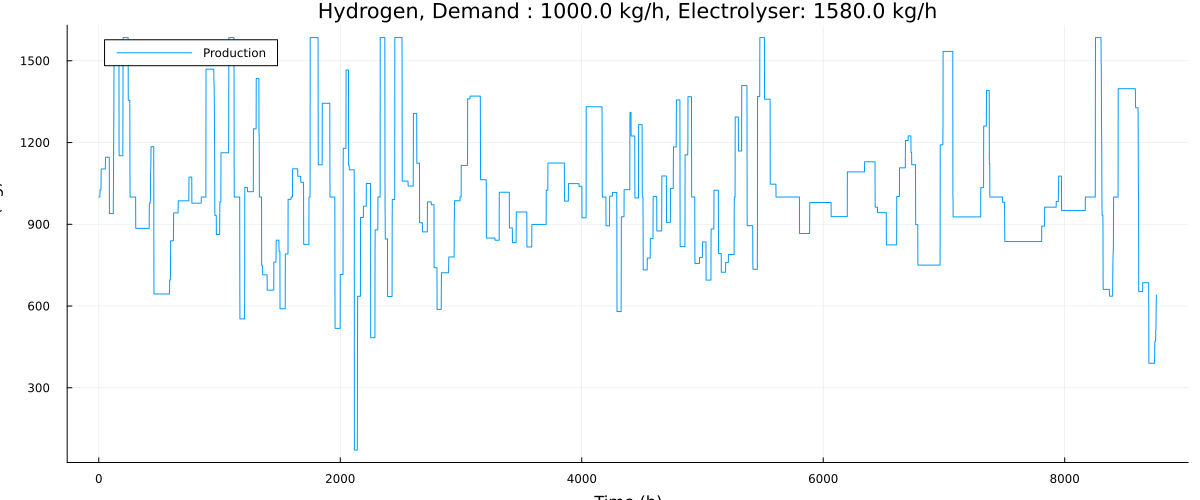

In [24]:
prod3

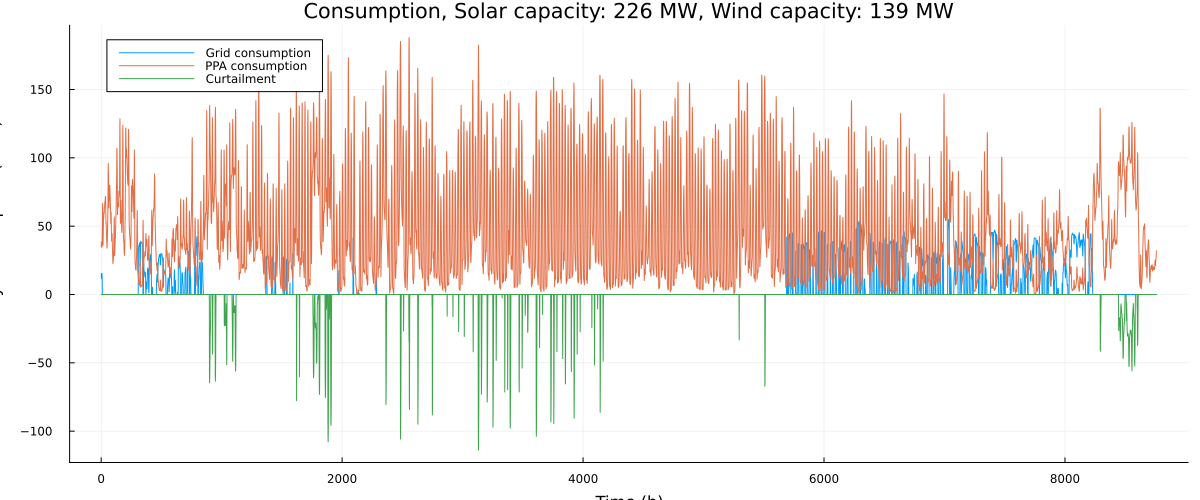

In [25]:
cons3

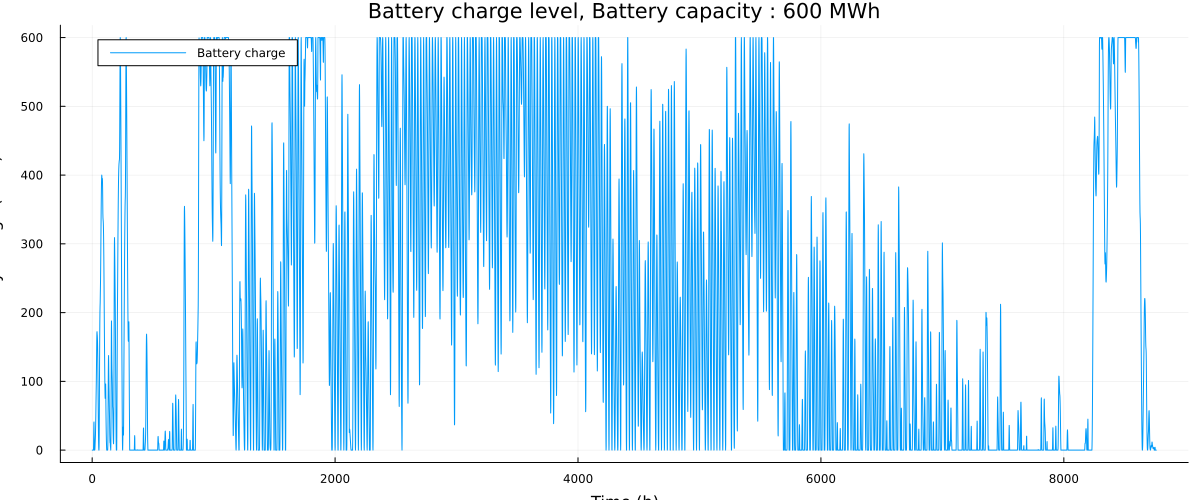

In [26]:
bat3

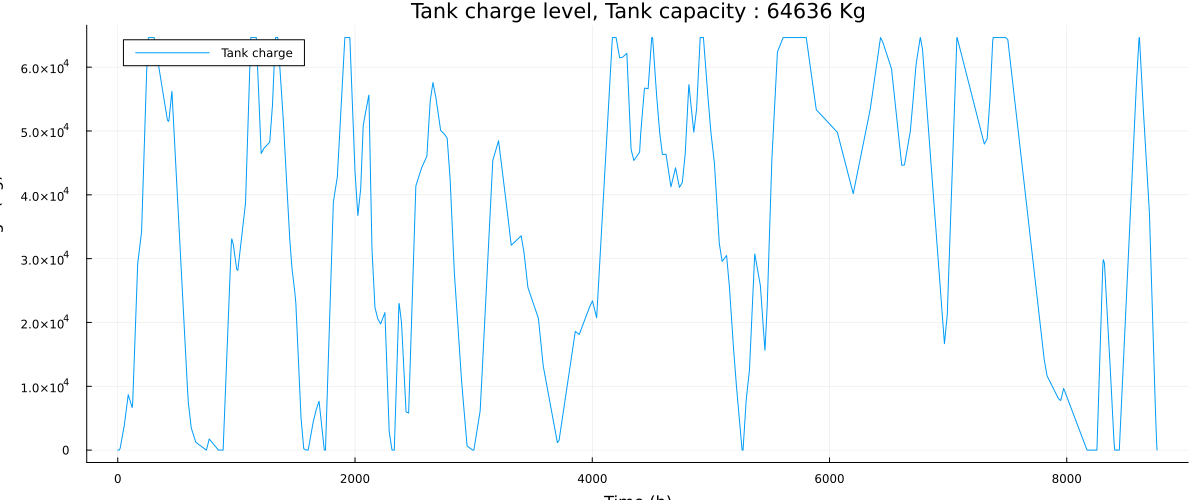

In [27]:
tank3